Classifiyng the two types of streets based on street view features

In [ ]:
import osmnx as ox
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
from shapely.geometry import Point, Polygon, MultiPoint, LineString, MultiLineString
from tqdm import tqdm
import shapely
from shapely import geometry, ops
from shapely.ops import linemerge
import momepy
import matplotlib.pyplot as plt
import math
import powerlaw

from pyrosm import OSM, get_data

import pyarrow.parquet as pq

In [19]:
def combine(elements):
    result_list = []
    for item in elements:
        if isinstance(item, int):
            result_list.append(item)
        elif isinstance(item, list):
            result_list.extend(item)
    return result_list

def clean_chains(G_primal):
    while True:
        nodes_to_remove = []
        
        for node in G_primal.nodes():
            neighbors = list(G_primal.neighbors(node))
            degree = G_primal.degree(node)
            if len(neighbors) == 2 and degree == 2:

                my_id = combine([i[2]['id'] for i in list(G_primal.edges(node, data=True))])
                lines = [i[2]['geometry'] for i in list(G_primal.edges(node, data=True))]

                multi_line = ops.linemerge(geometry.MultiLineString(lines))

                G_primal.add_edge(neighbors[1], neighbors[0], 
                                id=my_id,
                                geometry=multi_line,
                                new_edge=True)

                nodes_to_remove.append(node)
                
        if not nodes_to_remove: # if empty
            break
        G_primal.remove_nodes_from(nodes_to_remove)

    return G_primal

def get_slope(line):
    l = len(line.xy[0])-1
    x1, y1, x2, y2 = line.xy[0][0], line.xy[1][0], line.xy[0][l], line.xy[1][l]
    if x2 == x1: # straight vertical line
        return np.inf
    return (y2 - y1) / (x2 - x1)

    
def delta_angle(line1, line2): # angle between two lines
    slope1 = get_slope(line1)
    slope2 = get_slope(line2)

    if slope1 == np.inf and slope2 == np.inf:
        return 0
    
    elif slope1 == np.inf:
        return 90-math.degrees(abs(math.atan(slope2)))

    elif slope2 == np.inf:
        return 90-math.degrees(abs(math.atan(slope1)))
    
    elif slope1 * slope2 == -1:
        return 90

    else:
        angle_radians = math.atan(abs((slope2 - slope1) / (1 + slope1 * slope2)))
        angle_degrees = math.degrees(angle_radians)

        return angle_degrees

def new_angles(G,touch_buffer):
    nodes = G.nodes(data=True)
    for edges in list(G.edges()):
        u, v = edges
        a =  nodes[u]['geometry']
        b =  nodes[v]['geometry']
        touch_point = a.intersection(b)
        
        # if the touching point is not single point. Eg. Parallel lines
        if type(touch_point)!=Point: 
            angle=delta_angle(a,b)
        else: 
            # TODO: include inf buffer zone
            touch_point_b=touch_point.buffer(touch_buffer)
            cut_a = a.difference(a.difference(touch_point_b)) 
            cut_b = b.difference(b.difference(touch_point_b))
            cut_b = check_string(cut_b,touch_point)
            cut_a = check_string(cut_a,touch_point)
            angle = delta_angle(cut_a, cut_b)
        
        G[u][v]['new_angle'] = angle

    return G

def check_string(l,p):
    if type(l) == MultiLineString:
        for i in l.geoms:
            if i.touches(p):
                return i
    else: 
        return l

def merged_G_angle(G,tresh,attr):
    H = G.copy() 

    # find components that have a similar angle and merge them
    filtered_H = H.copy()
    edges_to_remove = [(u, v) for u, v, a in H.edges(data=True) if (a[attr] > tresh) or (a[attr] > (180 - tresh))]
    filtered_H.remove_edges_from(edges_to_remove)

    # Find connected components (groups of nodes to merge)
    components = [H.subgraph(c).copy() for c in nx.connected_components(filtered_H)]
    lengths = nx.get_node_attributes(G, "mm_len")
    geometries = nx.get_node_attributes(G, "geometry")
    
    mapping = {}
    length_map = {}
    geom_map = {}
    
    for comp in components:
        nodes = list(comp.nodes())
        
        # Merge by mean node coordinate
        mean_node = tuple(np.mean(np.array(nodes), axis=0))
        mapping.update({n: mean_node for n in nodes})
        
        # Sum up lengths
        length_map[mean_node] = np.sum([lengths.get(n, 0) for n in nodes])
        
        # Merge geometries (LineStrings → MultiLineString → merged line)
        lines = [geometries[n] for n in nodes if n in geometries]
        if lines:
            merged_geom = linemerge(MultiLineString(lines))
            geom_map[mean_node] = merged_geom
    
    # Relabel (merge) nodes in the original graph
    merged_H = nx.relabel_nodes(H, mapping)
    
    # Assign merged attributes
    nx.set_node_attributes(merged_H, length_map, "mm_len")
    nx.set_node_attributes(merged_H, geom_map, "geometry")
    
    return merged_H, mapping, length_map, geom_map

def get_dual_dir_con(subG,t_buffer,a_threshold,shape_df):

    # use graph data from the osmnx package
    if subG != None:
        shape_df = ox.graph_to_gdfs(subG,nodes=False)
        shape_df.crs = "EPSG:4326"
        shape_df = shape_df.to_crs(3857)
    else: # use shape file from pyrosm
        if shape_df.crs != "EPSG:4326": 
            shape_df.crs = "EPSG:4326" 
        shape_df = shape_df.to_crs(3857)

    shape_df = shape_df.reset_index().explode('geometry')
    u = shape_df.union_all()
    i = u.intersection(u)
    out = gpd.GeoDataFrame(geometry=gpd.GeoSeries(i, crs=shape_df.crs).explode()).reset_index(drop=True)
    shape_exploded_df = out.sjoin(shape_df[['osmid', 'geometry']], how="left", predicate="intersects")
    shape_exploded_df = shape_exploded_df.drop_duplicates(subset=['geometry'])

    shape_exploded_df = shape_exploded_df.reset_index(drop=True)
    shape_exploded_df['id'] = shape_exploded_df.index

    G_primal = momepy.gdf_to_nx(shape_exploded_df, approach="primal")
    G_primal = clean_chains(G_primal)
    _, lines = momepy.nx_to_gdf(G_primal)


    G_dual = momepy.gdf_to_nx(lines , approach='dual', multigraph=False, angles=True)
    G_dual=new_angles(G_dual,touch_buffer=t_buffer)

    angle_thresholds = a_threshold

    H, mapping, length_map, geom_map = merged_G_angle(G_dual,tresh=angle_thresholds,attr='new_angle')
    df_nodes = pd.DataFrame.from_dict(dict(H.nodes(data=True)), orient='index')
    gdf_merged = gpd.GeoDataFrame(df_nodes, geometry='geometry')
    gdf_merged['degree']=np.array([d for n, d in H.degree()])

    return gdf_merged, H

In [20]:
fp = get_data('Copenhagen')
osm = OSM(fp)
_, shape_df = osm.get_network(nodes=True)
G = momepy.gdf_to_nx(shape_df, approach="primal")
print(f'Nodes: {len(G)}')
shape_df['osmid']=shape_df['id']
gdf_merged, H = get_dual_dir_con(subG=None, t_buffer=5, a_threshold=30, shape_df=shape_df)

/home/lpsha/.conda/envs/umap-env/lib/python3.10/site-packages/momepy/utils.py:352: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


Nodes: 523762


In [22]:
folder_path = '/home/lpsha/s154446/street2vec/DINOv3/data_output/embeddings_vit_cph_strava/'

all_embeddings = []
all_file_names = []

files = [f for f in os.listdir(folder_path) if f.endswith('.parquet')]

for file in files:
    file_path = os.path.join(folder_path, file)
    parquet_file = pq.read_table(file_path, use_pandas_metadata=True)
    df = parquet_file.to_pandas()

    # Stack embeddings
    all_embeddings.append(np.stack(df['embedding'].values))
    
    # Collect file names
    all_file_names.append(df['file'].values)

# Combine into single arrays
embeddings = np.vstack(all_embeddings)
files_names = np.concatenate(all_file_names)

print(embeddings.shape)       # (total_rows, embedding_dim)

(199616, 1024)


In [26]:
gsv_cph=pd.read_csv("/data/google_street_view/copenhagen_strava/meta.csv")
geometry = [Point(xy) for xy in zip(gsv_cph.lon, gsv_cph.lat)]
cph_gdf = gpd.GeoDataFrame(gsv_cph, geometry=geometry, crs='EPSG:4326').to_crs(epsg=3857)

In [33]:
joined = gpd.sjoin_nearest(
    cph_gdf[['id', 'geometry']],
    gdf_merged[['degree','geometry']],
    how='inner',
    distance_col='dist_to_road')

/tmp/ipykernel_221456/3121129971.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3857
Right CRS: None

  joined = gpd.sjoin_nearest(


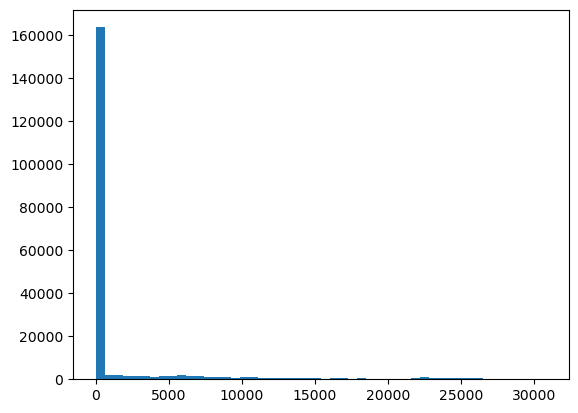

In [41]:
plt.hist(joined.dist_to_road.values,bins=50)
plt.show()

In [68]:
joined_filtered=joined.loc[joined.dist_to_road<5]

In [ ]:
file_to_idx = {fname: i for i, fname in enumerate(files_names)}
valid_files = [f for f in (joined_filtered.id+'.jpg').values if f in file_to_idx]
sorted_idx = [file_to_idx[f] for f in valid_files]
clean_emb=embeddings[sorted_idx]

X=clean_emb
y=joined_filtered.degree.values
y_b = y < 6

In [70]:
import umap
from sklearn.preprocessing import normalize, StandardScaler

In [97]:
reducer = umap.UMAP(
    n_neighbors=30,     # try 10, 15, or 30
    min_dist=0.1,       # try 0.0–0.2 for tighter clusters
    n_components=2,     
    metric='cosine'     
)

X_norm = StandardScaler().fit_transform(X)
umap_X = reducer.fit_transform(X_norm)

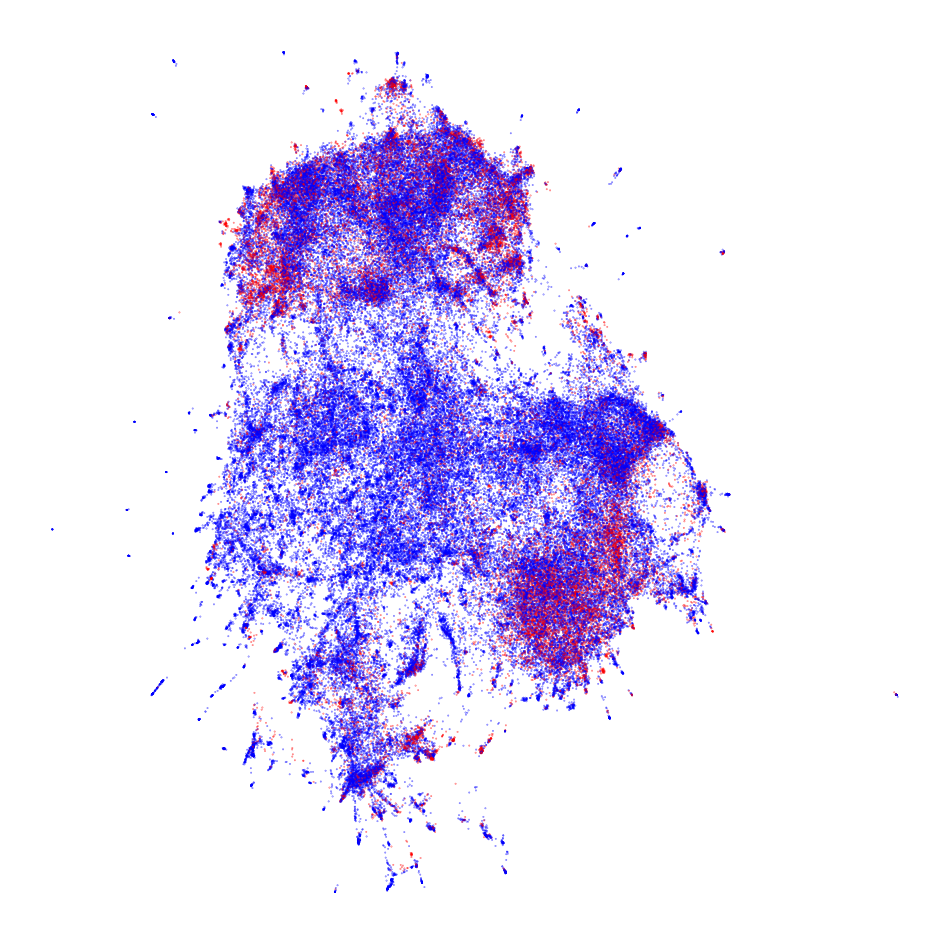

In [98]:
y_b = y < 6
plt.figure(figsize=(12,12))
plt.scatter(umap_X[:, 0], umap_X[:, 1],s=0.1,alpha=0.7,c=y_b,cmap='bwr')
plt.axis('off')
plt.show()

In [99]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y_b, test_size=0.2, random_state=42)

clf = XGBClassifier(
    n_estimators=1_000,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss'
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f'F1-Score: {f1_score(y_test, pred)}')

F1-Score: 0.3849448410123297
